# **Assignement 3 : Bird classification Image competition** - [MVA Recvis 21](https://www.kaggle.com/c/mva-recvis-2021/overview/)

# Importation des différentes librairies

In [ ]:
import numpy as np
import pandas as pd

import imageio
import imgaug as ia
from imgaug import augmenters as iaa

from __future__ import print_function, division
import os 
import time
import copy
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Libraries which includes pytorch
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, models, transforms

if not os.path.isdir('./experiments'):
    os.makedirs('./experiments')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/recvis21_a3-master/')

## Data initialization and loading

In [ ]:
# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 64 x 64 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set
data_transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

data_transforms_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

data_transforms_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

In [ ]:
# Initialization

dataset = 'bird_dataset/bird_dataset'
batch_size = 16
nclasses = 20
pin_memory = True

In [ ]:




train_datasets = datasets.ImageFolder(dataset + '/train_images',
                         transform=data_transforms_train)
val_datasets =  datasets.ImageFolder(dataset + '/val_images',
                                     transform=data_transforms_val)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory = pin_memory)
val_loader = torch.utils.data.DataLoader(val_datasets,batch_size=batch_size, shuffle=True, num_workers=1, pin_memory = pin_memory)

dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train':len(train_datasets), 'val':len(val_datasets)}

class_names_train = train_datasets.classes




In [ ]:
dict_class_names = {k+1:v for k, v in enumerate(class_names_train)}
dict_class_names

{1: '004.Groove_billed_Ani',
 2: '009.Brewer_Blackbird',
 3: '010.Red_winged_Blackbird',
 4: '011.Rusty_Blackbird',
 5: '012.Yellow_headed_Blackbird',
 6: '013.Bobolink',
 7: '014.Indigo_Bunting',
 8: '015.Lazuli_Bunting',
 9: '016.Painted_Bunting',
 10: '019.Gray_Catbird',
 11: '020.Yellow_breasted_Chat',
 12: '021.Eastern_Towhee',
 13: '023.Brandt_Cormorant',
 14: '026.Bronzed_Cowbird',
 15: '028.Brown_Creeper',
 16: '029.American_Crow',
 17: '030.Fish_Crow',
 18: '031.Black_billed_Cuckoo',
 19: '033.Yellow_billed_Cuckoo',
 20: '034.Gray_crowned_Rosy_Finch'}

## Visualization of some images

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


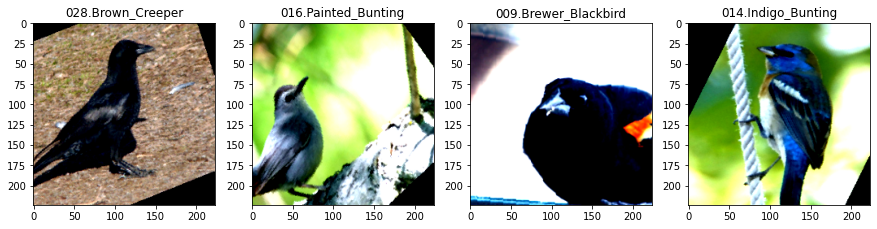

In [ ]:


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Viewing data examples used for training
fig, axis = plt.subplots(1, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{dict_class_names[label.item()]}") # add label

# Neural network and optimizer

Set Model Parameters’ .requires_grad attribute

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def choice_model(model_name, nclasses, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = None
    input_size = 0

    if model_name == "resnet34":
        """ Resnet34
        """
        model = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, nclasses)


    elif model_name == "resnet152":
        """ Resnet152
        """
        model = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, nclasses)
        # model.Dropout1 = nn.Dropout(p=0.9)


    elif model_name == "alexnet":
        """ Alexnet
        """
        model = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,nclasses)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,nclasses)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        model.classifier[1] = nn.Conv2d(512, nclasses, kernel_size=(1,1), stride=(1,1))
        model.nclasses = nclasses
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, nclasses)
        model.Dropout1 = nn.Dropout(p=0.9)
        model.Dropout2 = nn.Dropout(p=0.5)
        
    elif model_name == "inception":
        """ Inception v3
        """
        model = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        # Handle the auxilary net
        num_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs, nclasses)
        # Handle the primary net
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,nclasses)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    input_size = 224


    return model, input_size


# TRAINING

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#inspired from
# https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864


def save_models(epoch):
    torch.save(model.state_dict(), "resnetmodel_{}.model".format(epoch))
    print("Checkpoint saved")

def test():
    model.eval()
    test_acc = 0.0
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        test_acc += (prediction == labels).sum().item()

    test_acc = test_acc / 103

    return test_acc

best_acc_train = 0.0
best_acc_test = 0.0

def train(num_epochs):
    global best_acc_train
    global best_acc_test
    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for data in train_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += (prediction == labels).sum().item()

        train_acc = train_acc / 1082
        train_loss = train_loss / 1082

        test_acc = test()

        if (test_acc >= best_acc_test) and (train_acc >= best_acc_train):
            save_models(epoch)
            best_acc_test = test_acc
            best_acc_train = train_acc


        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))

In [ ]:
# Define a base model
name = 'resnet152'

feature_extract = True

# Initialize the model for this run
model, input_size = choice_model(name, nclasses, feature_extract, use_pretrained=True)

model.to(device)

# Print the model we just instantiated
print(model)

In [ ]:
if use_cuda:                                 
    model = model.cuda()       

criterion = nn.CrossEntropyLoss()        
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train(5)

Checkpoint saved
Epoch 0, Train Accuracy: 0.066543438077634 , TrainLoss: 3.0112536627792386 , Test Accuracy: 0.10679611650485436
Checkpoint saved
Epoch 1, Train Accuracy: 0.15434380776340112 , TrainLoss: 2.8816193926136067 , Test Accuracy: 0.22330097087378642
Checkpoint saved
Epoch 2, Train Accuracy: 0.300369685767098 , TrainLoss: 2.768055022093373 , Test Accuracy: 0.3786407766990291
Checkpoint saved
Epoch 3, Train Accuracy: 0.3706099815157117 , TrainLoss: 2.648390890269535 , Test Accuracy: 0.5145631067961165
Checkpoint saved
Epoch 4, Train Accuracy: 0.4805914972273567 , TrainLoss: 2.516617019603962 , Test Accuracy: 0.6796116504854369


In [ ]:
if use_cuda:                                 
    model = model.cuda()       

criterion = nn.CrossEntropyLoss()        
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train(5)

Checkpoint saved
Epoch 0, Train Accuracy: 0.5415896487985212 , TrainLoss: 2.4057680291301002 , Test Accuracy: 0.7475728155339806
Checkpoint saved
Epoch 1, Train Accuracy: 0.5757855822550831 , TrainLoss: 2.2597382562217785 , Test Accuracy: 0.7864077669902912
Epoch 2, Train Accuracy: 0.6303142329020333 , TrainLoss: 2.124428381981559 , Test Accuracy: 0.7572815533980582
Epoch 3, Train Accuracy: 0.634011090573013 , TrainLoss: 1.9809831695944455 , Test Accuracy: 0.7669902912621359
Checkpoint saved
Epoch 4, Train Accuracy: 0.678373382624769 , TrainLoss: 1.8591901180704509 , Test Accuracy: 0.7864077669902912


In [ ]:
if use_cuda:                                 
    model = model.cuda()       

criterion = nn.CrossEntropyLoss()        
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train(5)

Epoch 0, Train Accuracy: 0.6589648798521257 , TrainLoss: 1.7767156113538196 , Test Accuracy: 0.8446601941747572
Checkpoint saved
Epoch 1, Train Accuracy: 0.7014787430683919 , TrainLoss: 1.6318561213294152 , Test Accuracy: 0.8252427184466019
Checkpoint saved
Epoch 2, Train Accuracy: 0.7051756007393716 , TrainLoss: 1.5267181795317672 , Test Accuracy: 0.8349514563106796
Epoch 3, Train Accuracy: 0.7144177449168208 , TrainLoss: 1.4653216673133553 , Test Accuracy: 0.8252427184466019
Checkpoint saved
Epoch 4, Train Accuracy: 0.7070240295748613 , TrainLoss: 1.3769891616817764 , Test Accuracy: 0.8446601941747572


In [ ]:
if use_cuda:                                 
    model = model.cuda()       

criterion = nn.CrossEntropyLoss()        
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(5)

Epoch 0, Train Accuracy: 0.7597042513863216 , TrainLoss: 0.8889707073486667 , Test Accuracy: 0.8252427184466019
Epoch 1, Train Accuracy: 0.7587800369685767 , TrainLoss: 0.7972329859372208 , Test Accuracy: 0.8543689320388349
Checkpoint saved
Epoch 2, Train Accuracy: 0.7957486136783734 , TrainLoss: 0.7192798707489606 , Test Accuracy: 0.8640776699029126
Checkpoint saved
Epoch 3, Train Accuracy: 0.8059149722735675 , TrainLoss: 0.6395683096869816 , Test Accuracy: 0.8737864077669902
Epoch 4, Train Accuracy: 0.8105360443622921 , TrainLoss: 0.607902049136911 , Test Accuracy: 0.8543689320388349


In [ ]:
if use_cuda:                                 
    model = model.cuda()       

criterion = nn.CrossEntropyLoss()        
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train(5)

Epoch 0, Train Accuracy: 0.8687615526802218 , TrainLoss: 0.4472330326624146 , Test Accuracy: 0.8932038834951457
Epoch 1, Train Accuracy: 0.8475046210720887 , TrainLoss: 0.5213764249286899 , Test Accuracy: 0.9029126213592233
Epoch 2, Train Accuracy: 0.8715341959334566 , TrainLoss: 0.4350322597348536 , Test Accuracy: 0.9029126213592233
Epoch 3, Train Accuracy: 0.8622920517560074 , TrainLoss: 0.4347304071604434 , Test Accuracy: 0.8932038834951457
Epoch 4, Train Accuracy: 0.8595194085027726 , TrainLoss: 0.46698262114181094 , Test Accuracy: 0.8932038834951457


In [ ]:
if use_cuda:                                 
    model = model.cuda()       

criterion = nn.CrossEntropyLoss()        
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train(20)

Epoch 0, Train Accuracy: 0.8521256931608133 , TrainLoss: 0.48751629974396965 , Test Accuracy: 0.9029126213592233
Epoch 1, Train Accuracy: 0.8502772643253235 , TrainLoss: 0.512719975987556 , Test Accuracy: 0.8932038834951457
Epoch 2, Train Accuracy: 0.8595194085027726 , TrainLoss: 0.49215505876735044 , Test Accuracy: 0.8640776699029126
Epoch 3, Train Accuracy: 0.8576709796672828 , TrainLoss: 0.468337936784776 , Test Accuracy: 0.8446601941747572
Epoch 4, Train Accuracy: 0.8604436229205176 , TrainLoss: 0.48488739028214967 , Test Accuracy: 0.8932038834951457
Epoch 5, Train Accuracy: 0.8807763401109058 , TrainLoss: 0.42671656884018905 , Test Accuracy: 0.9029126213592233
Checkpoint saved
Epoch 6, Train Accuracy: 0.9011090573012939 , TrainLoss: 0.3621980813564302 , Test Accuracy: 0.912621359223301
Epoch 7, Train Accuracy: 0.8743068391866913 , TrainLoss: 0.4256907325244875 , Test Accuracy: 0.883495145631068
Epoch 8, Train Accuracy: 0.8844731977818854 , TrainLoss: 0.39579937611181504 , Test Acc

# **Prediction Set up**

In [ ]:
model.load_state_dict(torch.load('./resnetmodel_0.model'))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('./resnetmodel_6.model'))

<All keys matched successfully>

In [ ]:
# Directory of mistery dataset
test_dir = dataset + '/test_images/mistery_category'
outfile = 'experiments/kaggle_jtr.csv'

In [ ]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')



In [ ]:

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms_test(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))

        if use_cuda:
            data = data.cuda()

        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/517 [00:00<?, ?it/s]

Succesfully wrote experiments/kaggle_jtr.csv, you can upload this file to the kaggle competition website


In [ ]:
torch.save(model.state_dict(), "resnet_5_epochs_cool.model")

In [ ]:
torch.save(model.state_dict(), "resnet_5_epochs_6.model")